In [2]:
import torch
from torch import nn
import torch.nn.functional as F
#from torchsummary import summary
from tqdm import tqdm
import os
from torchvision import transforms
from torch.utils.data import DataLoader,random_split,Dataset
from PIL import Image,UnidentifiedImageError
import string
import matplotlib.pyplot as plt


In [1]:
import kagglehub
path = kagglehub.dataset_download("akashguna/large-captcha-dataset")
#Hyper parameters
#DATA_DIR='/kaggle/input/captcha-dataset'
DATA_DIR = '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset'
BATCH_SIZE=128
VAL_SPLIT=0.05

#AFFN
AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=1

#CRNN
CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26*2+10
OUTPUT_LENGTH=5

#Train
SAVE_EPOCH=5
VAL_EPOCH=1
EPOCHS=20

In [4]:
print(path)

/kaggle/input/large-captcha-dataset


In [5]:
def remove_image(image_path):
    try:
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Successfully removed the image: {image_path}")
        else:
            print(f"Image not found: {image_path}")
    except Exception as e:
        print(f"Error occurred while trying to remove the image: {e}")


image_to_remove = f'{DATA_DIR}/4q2wA.png'
remove_image(image_to_remove)

Error occurred while trying to remove the image: [Errno 30] Read-only file system: '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset/4q2wA.png'


In [7]:
DATA_DIR = '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset'

In [8]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:


chars = string.ascii_letters + string.digits
char_idx_dict = {character: index for index, character in enumerate(chars)}

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.labels_indices = []

        for f in os.listdir(root_dir):
            if f.lower().endswith(('png', 'jpg', 'jpeg')):
                img_path = os.path.join(root_dir, f)
                try:
                    with Image.open(img_path) as img:
                        img.verify()
                    self.image_paths.append(img_path)
                    label_str = os.path.splitext(f)[0]
                    self.labels.append(label_str)
                    label_idx = [char_idx_dict[c] for c in label_str if c in char_idx_dict]
                    self.labels_indices.append(torch.tensor(label_idx, dtype=torch.long))
                except (UnidentifiedImageError, IOError) as e:
                    logging.warning(f"Skipping invalid image file {img_path}. Error: {e}")

        logging.info(f"Loaded {len(self.image_paths)} valid images from {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Defensive: try to find a valid image up to dataset size attempts to avoid infinite loops
        attempts = 0
        size = len(self.image_paths)
        while attempts < size:
            img_path = self.image_paths[index]
            try:
                with Image.open(img_path) as image:
                    image = image.convert('RGB')
                label_tensor = self.labels_indices[index]
                if self.transform:
                    image = self.transform(image)
                return image, label_tensor
            except (UnidentifiedImageError, IOError) as e:
                logging.warning(f"Skipping problematic image file {img_path}. Error: {e}")
                index = (index + 1) % size
                attempts += 1

        raise RuntimeError("No valid images found in the dataset.")

def get_dataloader(data_directory, batch_size=32, val_split=0.2, shuffle=True, num_workers=0):
    transform = transforms.Compose([
        transforms.Resize((40, 150)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x / 255.0)
    ])

    dataset = CustomDataset(root_dir=data_directory, transform=transform)
    total_size = len(dataset)
    if total_size == 0:
        raise RuntimeError("No valid images found in the dataset directory.")

    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader



In [10]:
train_loader, val_loader = get_dataloader(data_directory=DATA_DIR,batch_size=BATCH_SIZE,val_split=VAL_SPLIT,shuffle=True)

In [11]:
X,y = next(iter(train_loader))
print(X.shape)
print(y.shape)

torch.Size([128, 1, 40, 150])
torch.Size([128, 5])


In [12]:
class Encoder(nn.Sequential):
  def __init__(self,n,kernel_size,stride):
    super().__init__(
        nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
        nn.BatchNorm2d(num_features=4**n),
        nn.ReLU(inplace=False)
    )

In [13]:
class Decoder(nn.Sequential):
  def __init__(self,n,kernel_size,stride):
    super().__init__(
        nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
        nn.BatchNorm2d(num_features=4**(n-1)),
        nn.ReLU(inplace=False)
    )

In [14]:
class AFFN(nn.Module):
  def __init__(self,n):
    super().__init__()
    self.n= n
    self.alpha = nn.Parameter(torch.randn(n-1).to(device)).to(device)
    self.encoders = []
    self.decoders = []
    for  i in range(1,n+1):
      self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))
    for  i in range(n,0,-1):
      self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

  def forward(self,x):
    residuals = []
    for i,enc in enumerate(self.encoders):
      x= enc(x)
      if i < self.n-1:
        x = x * (1 - self.alpha[i])
        residuals.append(x * self.alpha[i])
    for i,dec in enumerate(self.decoders):
      x= dec(x)
      if i < self.n-1:
        x= x + residuals.pop()
    return x


In [15]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  # Should be 5 for 5 characters
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)

        # CNN feature extraction
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        # Initialize hidden and cell states
        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)

        outputs = []

        # Generate 5 characters sequentially
        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 5, vocab_size)

        return outputs

In [16]:
output=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)(torch.zeros((2,64,256,256)).to(device))


In [17]:
output.shape

torch.Size([2, 5, 62])

In [18]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.affn=AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        affn_out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(affn_out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [19]:
CaptchaCrackNet()


CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [20]:
def loss_fn(preds,target):
    ce_loss=F.cross_entropy(preds,target)
    return ce_loss

torch.manual_seed(42)
def train(model,train_loader,val_loader,optimizer,loss_fn,epochs):
    train_history=[]
    val_history=[]
    model.to(device)
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        model.train()
        avg_loss=0
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):
            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)

            loss=loss_fn(preds.reshape(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
        avg_loss/=len(train_loader)
        train_history.append(avg_loss)
        print(f"Loss: {avg_loss}")

        eval_loss=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss = loss_fn(preds.reshape(-1, VOCAB_SIZE), y.reshape(-1))

                    eval_loss+=loss.item()
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}",eval_loss)

        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'seed': 42
}, path)
    torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'seed': 42
}, 'final final.pth')
    return train_history,val_history

In [21]:

model=CaptchaCrackNet().to(device)
optimizer=torch.optim.Adam(model.parameters())

In [25]:
checkpoint = torch.load(r'/content/10 add gc.pth', map_location=device)
# Restore states
print("Checkpoint keys:", checkpoint.keys())
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Checkpoint keys: dict_keys(['model_state_dict', 'optimizer_state_dict', 'seed'])


In [ ]:
#train_history,val_history=train(model,train_loader,val_loader,optimizer,nn.CrossEntropyLoss(),EPOCHS)


In [ ]:
# x_values = list(range(1, EPOCHS + 1))
# plt.plot(x_values, train_history, label='Train')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training History')
# plt.show()

In [26]:
characters = string.ascii_letters + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

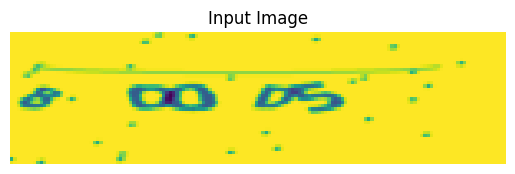

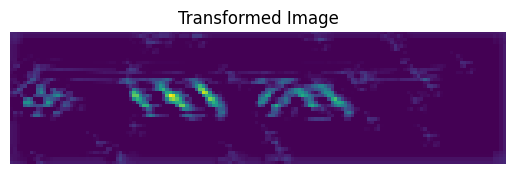

Output shape: torch.Size([1, 5, 62])
Predicted indices: [60, 52, 52, 29, 57]
Predicted text: 800D5
Ground truth label: tensor([60, 52, 52, 29, 57])
Actual label: 800D5


In [42]:
with torch.no_grad():
    for X, y in train_loader:
        X_sample = X[0]
        y_sample = y[0]

        img = X_sample.cpu().numpy().transpose(1, 2, 0)
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

        X_input = X_sample.unsqueeze(0).to(device)
        output = model(X_input)
        X1 = model.affn(X_input)

        img_trans = X1[0].cpu().numpy().transpose(1, 2, 0)
        plt.imshow(img_trans)
        plt.title("Transformed Image")
        plt.axis('off')
        plt.show()

        print("Output shape:", output.shape)

        pred_indices = output.squeeze(0).argmax(dim=1)
        print("Predicted indices:", pred_indices.tolist())
        print("Predicted text:", to_text(pred_indices))
        print("Ground truth label:", y_sample)
        print("Actual label:",to_text(y_sample))
        break

In [44]:
def evaluate(model, data_loader, criterion):
    model.eval()
    total_samples = 0
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            output = output.reshape(-1, output.shape[-1])
            target = target.view(-1)

            loss = criterion(output, target)
            total_loss += loss.item()


            _, pred = torch.max(output, dim=1)
            correct_samples += pred.eq(target).sum().item()
            total_samples += target.numel()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100.0 * correct_samples / total_samples
    print(f'Average test loss: {avg_loss:.4f}, Accuracy: {correct_samples}/{total_samples} ({accuracy:.2f}%)')

In [34]:
evaluate(model,data_loader=val_loader,criterion=nn.CrossEntropyLoss())

Average test loss: 0.0312, Accuracy: 20429/20580 (99.27%)
